# 使用国内资产复现bender的论文

In [1]:
import os, sys, argparse, logging

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *
from backtest import *

## 1.按步骤分解

In [2]:
# 读入资产数据
asset_data_raw = getAssetData().fillna(method='ffill')
asset_data = asset_data_raw.rolling(22).mean()

# 读入因子数据
factor_data_raw = getFactorData().reindex(asset_data.index).fillna(method='ffill').rolling(22).mean()
factor_data = factor_data_raw.rolling(22).mean()

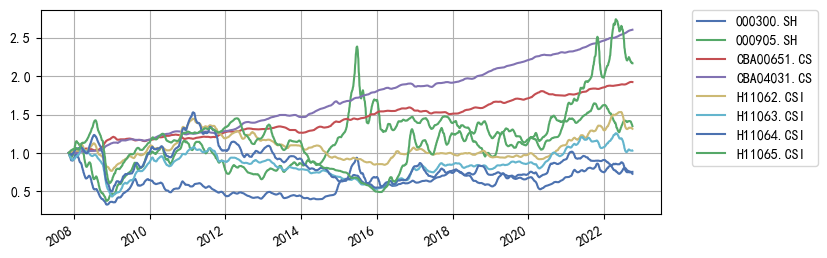

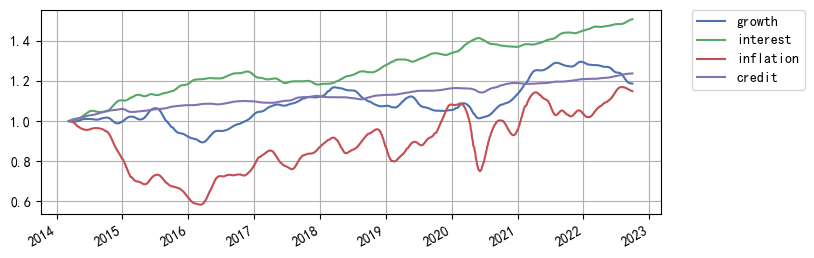

In [3]:
(asset_data.dropna()/asset_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

(factor_data.dropna()/factor_data.dropna().iloc[0]).plot(figsize=(8,3), grid=True)
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

In [4]:
id_date = datetime(2019, 8, 31)
look_back = 252 * 3

tmp_asset_data = asset_data.loc[:id_date].iloc[-look_back:]
tmp_factor_data = factor_data.loc[:id_date].iloc[-look_back:]

asset_returns = tmp_asset_data.pct_change().fillna(0)
factor_returns = tmp_factor_data.pct_change().fillna(0)



### Step 2： Estimating Asset Class Factor Exposures

In [5]:
exposure = getFatorExposureFrame(asset_returns, factor_returns)
exposure

,growth,interest,inflation,credit
000300.SH,0.937253,-0.447460,-0.903361,0.626373
000905.SH,1.830626,0.422987,-0.059880,0.533180
CBA00651.CS,-0.650406,1.274026,-1.653454,-1.185731
CBA04031.CS,-0.604323,1.471659,-0.736368,1.012018
H11062.CSI,-1.104552,-1.040397,0.795755,-0.110878
H11063.CSI,-0.143726,-0.584801,0.781902,-0.777901
H11064.CSI,-0.726726,-1.183183,0.683278,-1.327418
H11065.CSI,0.461854,0.087169,1.092127,1.230356


### Step 3: Constructing Factor-Mimicking Portfolios

In [6]:
fmp = getFactorMimickingPortfolio(asset_returns, factor_returns)
fmp

,growth,interest,inflation,credit
000300.SH,0.064533,-0.442197,-0.526690,0.253635
000905.SH,0.276956,0.192508,0.313767,-0.149442
CBA00651.CS,0.016957,0.009106,-0.223121,-0.346134
CBA04031.CS,-0.240524,0.359817,0.107393,0.361558
H11062.CSI,-0.218033,-0.309415,0.129171,0.003980
H11063.CSI,0.135942,0.194315,0.289506,-0.144394
H11064.CSI,-0.078620,0.022312,-0.054602,-0.002742
H11065.CSI,0.042788,-0.026446,-0.035424,0.023539


In [7]:
date_range = [datetime(2018,1,1), datetime(2021,12,31)]

In [79]:
# fmp回测表现
class FmpStrategy(Strategy):
    def __init__(self, factor_data=None, factor_name=None, scale=1):
        super().__init__()
        self._factor_data = factor_data
        self._factor_name = factor_name
        self._scale = scale

    def run(self, asset_data):
        asset_data = asset_data.rolling(22, min_periods=1).mean()
        tmp_asset_returns = asset_data.pct_change().fillna(0)
        tmp_factor_data = self._factor_data.reindex(asset_data.index)
        tmp_factor_returns = tmp_factor_data.pct_change().fillna(0)

        return getFactorMimickingPortfolio(tmp_asset_returns, tmp_factor_returns, scale=self._scale)[self._factor_name]
      

In [80]:
fmp_value = pd.DataFrame()
fmp_weights = {}

for factor in factor_data.columns:
    fmp_backtest = BacktestManager(
        FmpStrategy(factor_data=factor_data, factor_name=factor, scale=None), 
        asset_data_raw, 
        date_range = date_range, 
        frequency = 252//12, 
        look_back = 252*3, 
    )
    fmp_backtest.run()
    fmp_value[factor] = fmp_backtest.getHistoricalValue()
    weights_dict = fmp_backtest._historcial_weights
    fmp_weights[factor] = pd.DataFrame(columns=asset_data.columns)
    for id_date, weights in weights_dict.items():
        fmp_weights[factor].loc[id_date] = weights.reindex(fmp_weights[factor].columns)



100%|██████████| 973/973 [00:05<00:00, 179.99it/s]


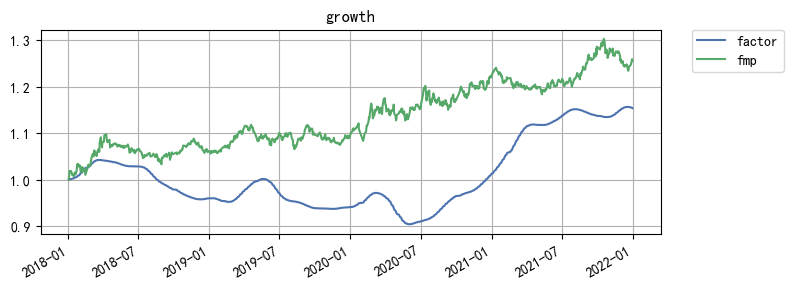

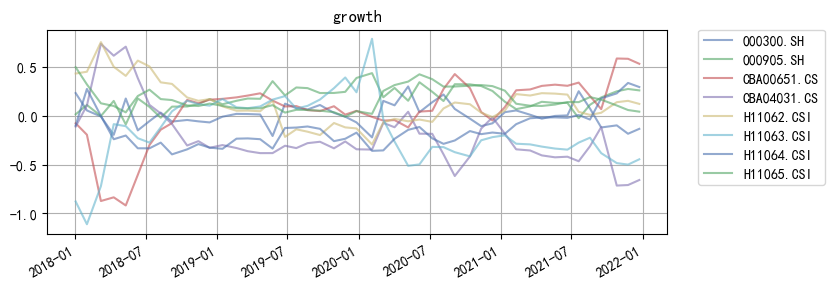

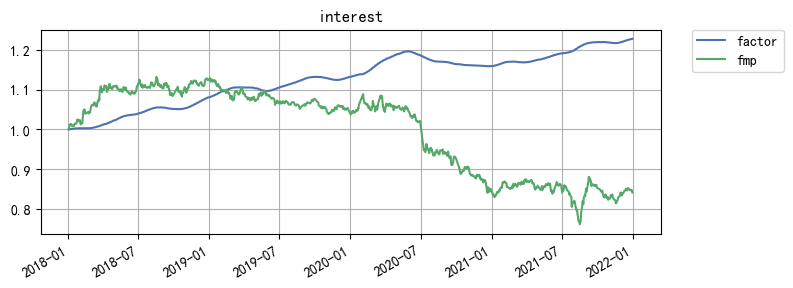

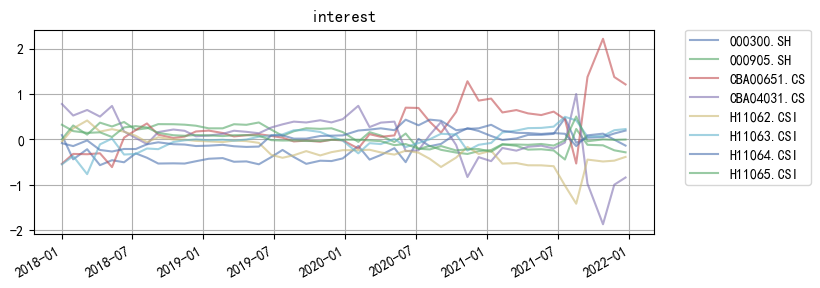

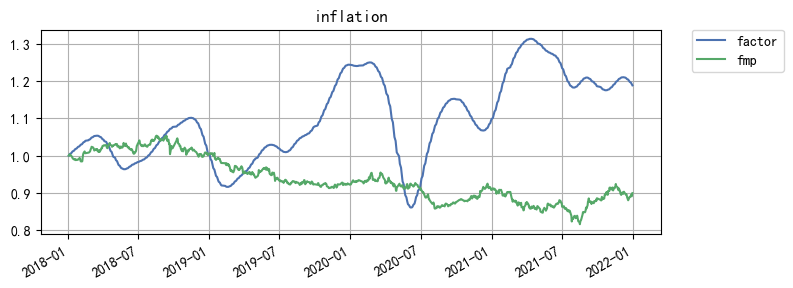

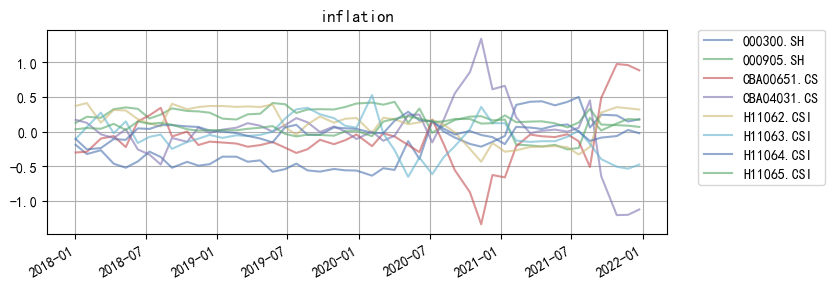

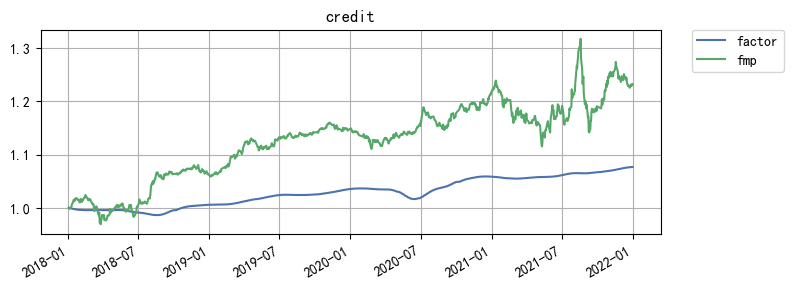

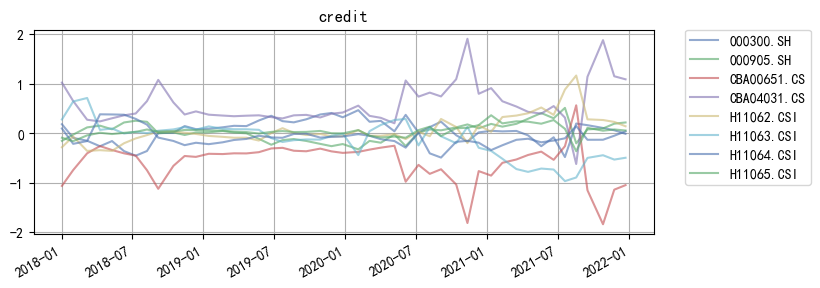

In [81]:
tmp_factor_data = factor_data.reindex(fmp_value.index)
tmp_factor_data /= tmp_factor_data.iloc[0]
fmp_value /= fmp_value.iloc[0]

for factor in factor_data.columns:
    pd.DataFrame({
        'factor': tmp_factor_data[factor], 
        'fmp': fmp_value[factor], 
    }).plot(figsize=(8,3), grid=True, title=factor)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

    fmp_weights[factor].plot(figsize=(8,3), grid=True, title=factor, alpha=0.6)
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)



### Step 4: Forecasting Factor-Mimicking Portfolio Return

In [82]:
# 使用历史收益率作为fmp收益率预测
fmp_lookback = 252 * 1
fmp_return = fmp_value.loc[:id_date].iloc[-fmp_lookback:].pct_change().fillna(0)


In [98]:
fmp_return

,growth,interest,inflation,credit
2020-12-11,0.000000,0.000000,0.000000,0.000000
2020-12-14,-0.002585,0.002340,-0.003325,0.000246
2020-12-15,0.001614,-0.001853,0.002752,-0.001851
2020-12-16,-0.001223,-0.004108,-0.000513,0.000181
2020-12-17,0.002214,-0.004270,0.002077,-0.000447
...,...,...,...,...
2021-12-17,-0.002517,-0.001026,-0.006825,-0.006514
2021-12-20,-0.008726,0.007042,-0.010056,-0.004455
2021-12-21,0.002213,-0.001940,0.002572,0.001080
2021-12-22,0.004015,-0.000675,0.003717,-0.000230


### Step 5: Constructing the Optimal Factor Portfolio

In [99]:
def optimalFactorPortfolio(fmp_return):
    cov = np.matrix(fmp_return.cov()).astype('float64')
    w0 = [1/fmp_return.shape[1]] * fmp_return.shape[1]
    Q = np.matrix((1+fmp_return).cumprod().iloc[-1]-1).astype('float64').T

    # print(cov, w0, Q)

    def factorPortfolioReturn(w,cov,Q): 
        w = np.matrix(w).astype('float64').T
        return -(w.T @ Q - 0.5 * w.T @ cov @ w)[0,0]
    
    #set constraints
    cons = [] 
    cons.append({'type': 'eq', 'fun': lambda w: sum(w) - 1})
    bounds = tuple([(0,1)] * fmp_return.shape[1])

    factor_weights = minimize(factorPortfolioReturn, w0, constraints=cons, args=(cov, Q), bounds=bounds,  method='SLSQP').x
    return pd.DataFrame(factor_weights, index=fmp_return.columns).T

In [100]:
fmp_weights = optimalFactorPortfolio(fmp_return)
fmp_weights

,growth,interest,inflation,credit
0,1.0,0.0,0.0,9.159340e-16


### Step 6: Inferring Expected Returns for Asset Classes

In [127]:
def getAssetExpectedReturns(fmp_weights, factor_weights, asset_returns):
    asset_weights = np.matrix(factor_weights).dot(np.matrix(fmp_weights).T)
    cov = np.matrix(asset_returns.cov()).astype('float64') * 252
    alpha = cov @ asset_weights
    return pd.DataFrame(alpha,index=asset_returns.columns).T

In [128]:
tmp_asset_returns = asset_data_raw.pct_change().loc[:id_date].iloc[-252:]
alpha = getAssetExpectedReturns(fmp_weights, fmp, tmp_asset_returns)
alpha

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
0,2.197871,2.289376,0.014163,0.003108,-0.706819,1.284702,0.255627,1.492605
